In [1]:
import jittor
import jittor as jt
import jittor.nn as nn
from jittor import transform as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ImageNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = jittor.dataset.CIFAR10(
    root='./data/cifar_10/', 
    train=True, 
    transform=transform)
trainloader = trainset.set_attrs(batch_size=batch_size, shuffle=True, num_workers=2)

testset = jittor.dataset.CIFAR10(
    root='./data/cifar_10/', 
    train=False, 
    transform=transform)
testloader = testset.set_attrs(batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

163MB [04:05, 695kB/s]                                                                                                 


Extracting ./data/cifar_10/cifar-10-python.tar.gz to ./data/cifar_10/
Files already downloaded and verified


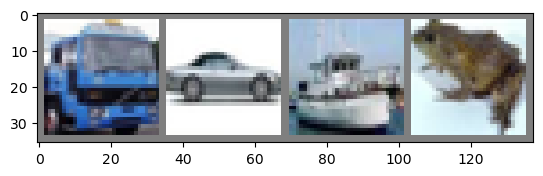

truck car   ship  frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
for images, labels in trainloader:
    break

# show images
imshow(jittor.misc.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))

In [4]:
import jittor.nn as nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # kernel_size=5, padding=2, stride=1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def execute(self, x):
        x = self.pool(nn.relu(self.conv1(x)))
        x = self.pool(nn.relu(self.conv2(x)))
        x = jt.flatten(x, 1) # flatten all dimensions except batch
        x = nn.relu(self.fc1(x))
        x = nn.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import jittor.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # zero the parameter gradients + backward + optimize
        optimizer.step(loss)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 1.891
[1,  6000] loss: 1.689
[1,  8000] loss: 1.556
[1, 10000] loss: 1.503
[1, 12000] loss: 1.432
[2,  2000] loss: 1.392
[2,  4000] loss: 1.375
[2,  6000] loss: 1.316
[2,  8000] loss: 1.271
[2, 10000] loss: 1.275
[2, 12000] loss: 1.220
Finished Training


In [7]:
PATH = './cifar_net.pth.tar'
jt.save(net.state_dict(), PATH)

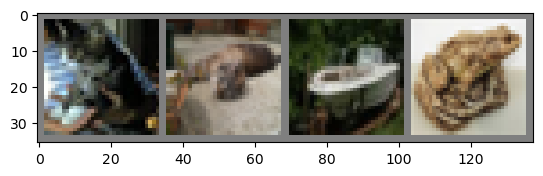

GroundTruth:  cat   cat   ship  frog 


In [8]:
for images, labels in trainloader:
    break

# print images
imshow(jittor.misc.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j].item()]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load(PATH)

In [10]:
outputs = net(images)

In [11]:
predicted = jt.argmax(outputs, 1)[0]

print('Predicted: ', ' '.join(f'{classes[predicted[j].item()]:5s}'
                              for j in range(4)))

Predicted:  horse frog  car   frog 


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with jittor.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = jittor.argmax(outputs, 1)[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with jt.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        predictions = jittor.argmax(outputs, 1)[0]
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.8 %
Accuracy for class: car   is 75.4 %
Accuracy for class: bird  is 39.6 %
Accuracy for class: cat   is 52.1 %
Accuracy for class: deer  is 36.7 %
Accuracy for class: dog   is 35.9 %
Accuracy for class: frog  is 59.4 %
Accuracy for class: horse is 57.0 %
Accuracy for class: ship  is 76.2 %
Accuracy for class: truck is 62.3 %


[1,  2000] loss: 1.131
[1,  4000] loss: 1.106
[1,  6000] loss: 1.065
[1,  8000] loss: 1.021
[1, 10000] loss: 1.022
[1, 12000] loss: 0.968
[2,  2000] loss: 1.057
[2,  4000] loss: 1.055
[2,  6000] loss: 1.016
[2,  8000] loss: 0.979
[2, 10000] loss: 0.987
[2, 12000] loss: 0.941
[3,  2000] loss: 1.021
[3,  4000] loss: 1.021
[3,  6000] loss: 0.984
[3,  8000] loss: 0.950
[3, 10000] loss: 0.958
[3, 12000] loss: 0.918
Finished Training


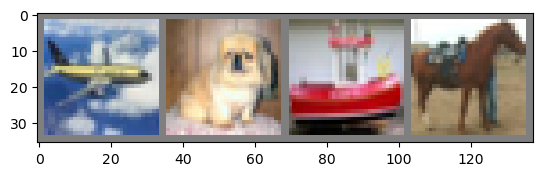

GroundTruth:  plane dog   ship  horse
Predicted:  plane dog   ship  horse
Accuracy of the network on the 10000 test images: 62 %
Accuracy for class: plane is 64.0 %
Accuracy for class: car   is 79.0 %
Accuracy for class: bird  is 56.1 %
Accuracy for class: cat   is 46.7 %
Accuracy for class: deer  is 50.6 %
Accuracy for class: dog   is 47.4 %
Accuracy for class: frog  is 74.6 %
Accuracy for class: horse is 61.3 %
Accuracy for class: ship  is 76.9 %
Accuracy for class: truck is 64.9 %


In [14]:
import jittor.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # zero the parameter gradients + backward + optimize
        optimizer.step(loss)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
PATH = './cifar_net.pth.tar'
jt.save(net.state_dict(), PATH)
for images, labels in trainloader:
    break

# print images
imshow(jittor.misc.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j].item()]:5s}' for j in range(4)))
net = Net()
net.load(PATH)
outputs = net(images)
predicted = jt.argmax(outputs, 1)[0]

print('Predicted: ', ' '.join(f'{classes[predicted[j].item()]:5s}'
                              for j in range(4)))
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with jittor.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = jittor.argmax(outputs, 1)[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with jt.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        predictions = jittor.argmax(outputs, 1)[0]
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


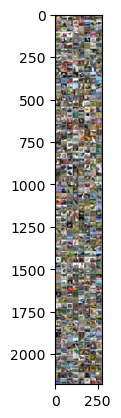

frog  truck truck deer  dog   truck cat   deer  horse dog   cat   cat   car   ship  car   truck bird  deer  plane dog   dog   car   car   ship  frog  truck bird  horse horse car   truck deer  frog  truck deer  plane ship  bird  truck frog  cat   horse ship  ship  cat   deer  plane deer  deer  truck truck bird  ship  frog  cat   dog   plane plane frog  dog   deer  plane frog  truck car   truck truck cat   deer  horse truck bird  dog   deer  deer  cat   ship  frog  cat   horse ship  horse car   frog  car   plane car   truck frog  bird  car   plane horse frog  frog  ship  plane dog   car   plane dog   bird  cat   cat   deer  bird  bird  cat   frog  horse cat   ship  deer  cat   bird  horse frog  truck deer  horse truck cat   horse car   bird  truck deer  deer  dog   horse ship  dog   car   cat   truck truck plane dog   plane deer  ship  cat   frog  deer  cat   ship  car   frog  frog  ship  car   deer  horse plane dog   dog   dog   frog  frog  dog   horse ship  car   truck frog  frog  hors

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # kernel_size=5, padding=2, stride=1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
print(len(trainloader))

98


In [7]:
def train(epoch, log_interval=50):
    # Set model to training mode
    net.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = net(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [8]:
def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [9]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304443
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.301237

Validation set: Average loss: 2.2996, Accuracy: 1320/10000 (13%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.299994
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.294102

Validation set: Average loss: 2.2564, Accuracy: 1920/10000 (19%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.261411
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.012493

Validation set: Average loss: 1.8765, Accuracy: 3262/10000 (33%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.836884
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.686578

Validation set: Average loss: 1.6198, Accuracy: 4034/10000 (40%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.553595
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.602320

Validation set: Average loss: 1.5182, Accuracy: 4414/10000 (44%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.529058
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.438675

Validation set: Average loss: 1.4414, Accuracy: 4755/10000 (48%)

Train Epoch: 7 [0/50000 (0%)

In [10]:
print(lossv)
print(accv)

[2.299613928794861, 2.256392848491669, 1.876457840204239, 1.619805282354355, 1.518169778585434, 1.4414478063583374, 1.4232818722724914, 1.3623399078845977, 1.3118795156478882, 1.2797702968120575, 1.2734809637069702, 1.2174232006072998, 1.2139506757259368, 1.1695201992988586, 1.173503965139389, 1.1722333431243896, 1.1278247237205505, 1.1557760179042815, 1.1285462141036988, 1.0894645363092423, 1.1275717735290527, 1.0987112402915955, 1.0933110982179641, 1.1119837045669556, 1.0559301167726516, 1.0590644776821136, 1.0682911992073059, 1.0479923099279405, 1.0619348376989364, 1.074267292022705]
[tensor(13.2000), tensor(19.2000), tensor(32.6200), tensor(40.3400), tensor(44.1400), tensor(47.5500), tensor(48.8000), tensor(51.3200), tensor(52.9900), tensor(53.6100), tensor(54.6500), tensor(56.4700), tensor(57.1400), tensor(58.8600), tensor(58.9900), tensor(59.4200), tensor(60.2300), tensor(59.5500), tensor(60.5200), tensor(62.4400), tensor(60.9600), tensor(61.9600), tensor(62.2500), tensor(61.4300

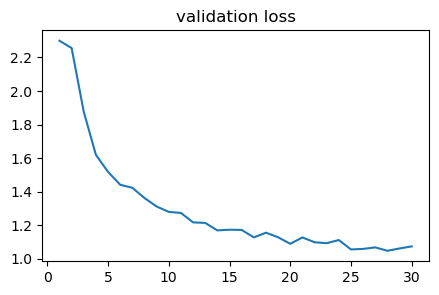

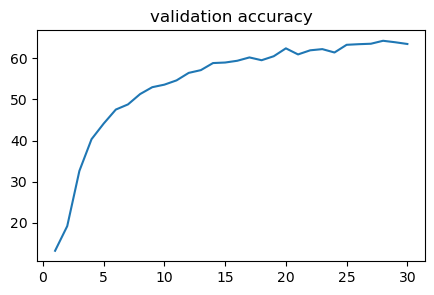

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

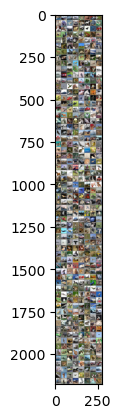

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   plane ship  ship 


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.3 %
Accuracy for class: car   is 66.9 %
Accuracy for class: bird  is 67.5 %
Accuracy for class: cat   is 41.8 %
Accuracy for class: deer  is 51.3 %
Accuracy for class: dog   is 46.2 %
Accuracy for class: frog  is 67.8 %
Accuracy for class: horse is 72.1 %
Accuracy for class: ship  is 82.4 %
Accuracy for class: truck is 69.7 %


In [17]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


In [18]:
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [19]:
model=resnet18()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [20]:
model=model.to(device)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [23]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [24]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.406033
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.456018

Validation set: Average loss: 1.1719, Accuracy: 5706/10000 (57%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.984529
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.928701

Validation set: Average loss: 1.0041, Accuracy: 6453/10000 (65%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.684575
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.600161

Validation set: Average loss: 0.7741, Accuracy: 7315/10000 (73%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.437608
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.465494

Validation set: Average loss: 1.0972, Accuracy: 6804/10000 (68%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.287727
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.244209

Validation set: Average loss: 1.1576, Accuracy: 6746/10000 (67%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.188417
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.130127

Validation set: Average loss: 1.4706, Accuracy: 6563/10000 (66%)

Train Epoch: 7 [0/50000 (0%)

In [25]:
lossv=[1.8424743473529817,1.1628164172172546, 1.2431526601314544, 1.0839487344026566, 1.012735441327095,  1.2685284435749054, 1.1464801728725433, 1.0911928087472915, 0.9414075911045074, 0.9006227761507034, 0.8733943849802017, 0.8753824204206466, 0.8772015184164047, 0.8810045659542084, 0.8831397294998169, 0.8856752693653107, 0.8879411369562149, 0.8932823687791824, 0.896161749958992, 0.8986354947090149, 0.898526182770729, 0.9017041057348252, 0.9057591944932938, 0.9078369855880737, 0.9095508426427841, 0.9103667616844178, 0.9136103391647339, 0.9131608724594116, 0.9150025457143783, 0.9168427675962448]
accv=[58.1400,58.0400, 55.4200,64, 68.8500,68.6700, 71.8100, 74.0400,77.9200, 78.9600, 79.6500, 79.8800,79.9300, 80.0400, 80.0200, 80.1100,79.9500, 80.0900, 80.1000, 80.0200, 80.0300, 80.0700,80.0600, 79.9700, 80, 80.0400, 80, 80.0500, 80.1000,80.0100]

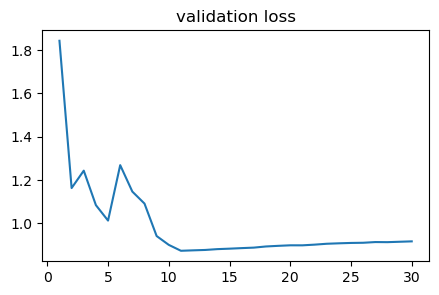

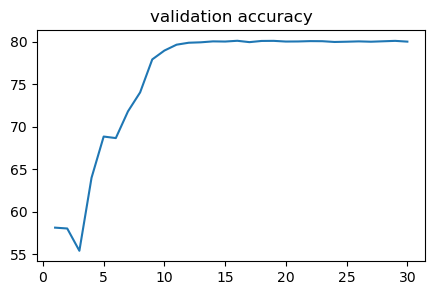

In [26]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [27]:
PATH = './cifar_resnet18.pth'
torch.save(model.state_dict(), PATH)

In [28]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torchvision.models.detection.retinanet import RetinaNet
from torch import Tensor
from typing import Any, List, Tuple

In [29]:
class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 10,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _load_state_dict(model: nn.Module, model_url: str, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet18(pretrained: bool = False, progress: bool = True, input_size: Tuple[int, int, int] = None, **kwargs: Any) -> DenseNet:
    model = _densenet('', 32, (4, 4, 4, 4), 64, pretrained, progress, **kwargs)
    model.name = "DenseNet18"
    return model

In [31]:
model=densenet18()
print(model)
model=model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [33]:
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

In [34]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [35]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.354757
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.478024

Validation set: Average loss: 1.3658, Accuracy: 5004/10000 (50%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.154098
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.056763

Validation set: Average loss: 1.0557, Accuracy: 6218/10000 (62%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.957642
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.925013

Validation set: Average loss: 1.0279, Accuracy: 6304/10000 (63%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.793385
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.747955

Validation set: Average loss: 0.9577, Accuracy: 6660/10000 (67%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.686055
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.699987

Validation set: Average loss: 0.9554, Accuracy: 6770/10000 (68%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.563364
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.587813

Validation set: Average loss: 0.9034, Accuracy: 7045/10000 (70%)

Train Epoch: 7 [0/50000 (0%)

In [36]:
print(lossv)
print(accv)

[1.3657531082630157, 1.0556892812252046, 1.027943307161331, 0.9577425748109818, 0.9554137796163559, 0.9034460097551346, 0.8702415555715561, 0.8531985580921173, 0.9217097908258438, 0.9070174515247345, 0.9708287864923477, 1.0928400933742524, 1.110358899831772, 1.0556019097566605, 1.1637250781059265, 1.184686753153801, 1.2084715366363525, 1.2486578822135925, 1.4161826968193054, 1.2224765121936798, 1.3139236748218537, 1.2503756761550904, 1.3534541487693788, 1.3576031267642974, 1.4157716870307921, 1.3827183961868286, 1.366351193189621, 1.3869555234909057, 1.4127777576446534, 1.6149331510066987]
[tensor(50.0400), tensor(62.1800), tensor(63.0400), tensor(66.6000), tensor(67.7000), tensor(70.4500), tensor(70.4600), tensor(73.2000), tensor(71.6200), tensor(72.3700), tensor(72.5200), tensor(71.1500), tensor(71.5400), tensor(72.8800), tensor(72.8100), tensor(72.6300), tensor(73.3100), tensor(73.7500), tensor(72.7500), tensor(74.6200), tensor(73.4600), tensor(76.0100), tensor(73.9100), tensor(75.4

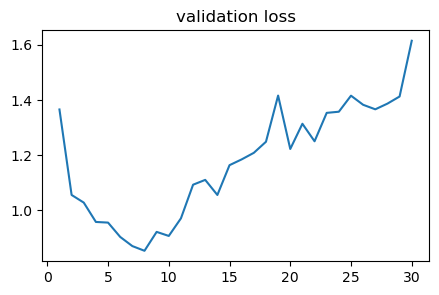

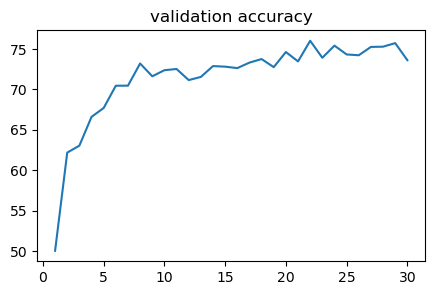

In [37]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
PATH = './cifar_densenet18.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.se = SEBlock(growth_rate)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.se(out)
        out = torch.cat([out, x], 1)
        return out

class DenseNetSE(nn.Module):
    def __init__(self, growth_rate=12, block_config=(4,4,4,4), num_classes=10, reduction=16):
        super(DenseNetSE, self).__init__()

        self.growth_rate = growth_rate

        num_channels = 2*growth_rate

        self.features = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        for i, num_layers in enumerate(block_config):
            block = nn.Sequential()
            for j in range(num_layers):
                layer = DenseLayer(num_channels, growth_rate)
                block.add_module('Layer_{}'.format(j), layer)
                num_channels += growth_rate
            self.features.add_module('Block_{}'.format(i), block)
            if i != len(block_config)-1:
                transition = nn.Sequential(
                    nn.BatchNorm2d(num_channels),
                    nn.Conv2d(num_channels, num_channels//2, kernel_size=1, bias=False),
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                )
                self.features.add_module('Transition_{}'.format(i), transition)
                num_channels //= 2
        
        self.features.add_module('BN_Last', nn.BatchNorm2d(num_channels)) # 加上全局BN层

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

model=DenseNetSE()
print(model)
model=model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
def train(epoch, log_interval=50):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(trainloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))

def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))

    

In [ ]:
%%time
epochs = 30

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
    
print(lossv)
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class SENet(nn.Module):
    def __init__(self, block, layers, num_classes=10, reduction=16):
        super(SENet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.se = SEBlock(512 * block.expansion, reduction)

    def make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.se(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
net = SENet(BasicBlock, [2, 2, 2, 2], reduction=16)
print(net)